In [1]:
from utils.epg import *
import matplotlib.pyplot as plt
from copy import copy
cmap = copy(plt.cm.get_cmap("jet"))
from scipy.optimize import least_squares

In [2]:
degree = r"${}^{\circ}$"
GeV = "GeV"
GeV2 = "GeV"+r"${}^{2}$"
GeVc = "GeV/c"
GeVc2 = "(GeV/c)"+r"${}^{2}$"

In [3]:
import matplotlib
# initial settings
pgf_with_latex = {
		"pgf.texsystem": "pdflatex",
		"text.usetex": True,            # use LaTeX to write all text
		"font.family": "sans-serif",         
		"font.sans-serif": "Helvetica",
		"font.size": 25,				# default font size
		"axes.labelsize": 24,			# x and y label size
		"axes.titlesize": 24,           # subfigure title size, i.e. title size when one figure
		"legend.fontsize": 22,			# legend size
		"xtick.labelsize": 23,			# x axis tick label size
		"ytick.labelsize": 23,			# y axis tick label 
		"figure.titlesize": 25,         # Figure title size, useful when you have multiple plots in one canvas.
		"pgf.preamble": r"\usepackage{xcolor}"     # xcolor for colours
}
matplotlib.rcParams.update(pgf_with_latex)


## Simulation

In [4]:
#pi0 simulation from Andrey, inb, rec
fname = "~/Dropbox (MIT)/data/MC/dnp/pi0DNPInbREC.root"
epg = epgFromROOT(fname, rec=True)
dvpi0 = epg.getDVpi0(correction=False)
dvcs = epg.getDVCS(correction=False, sub2g=False)
pi0MCdnpInb = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_ep": epg.df_ep, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg, "df_MC":epg.df_MC}

In [5]:
#dvcs from simulation, vz correct, vxvy (0, 0), rec
fname = "~/Dropbox (MIT)/data/MC/nonradVzCorrInbREC.root"
epg = epgFromROOT(fname, rec=True)
dvpi0 = epg.getDVpi0(correction=False)
dvcs = epg.getDVCS(correction=False, sub2g=False)
dvcsMCInb = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg, "df_MC": epg.df_MC}

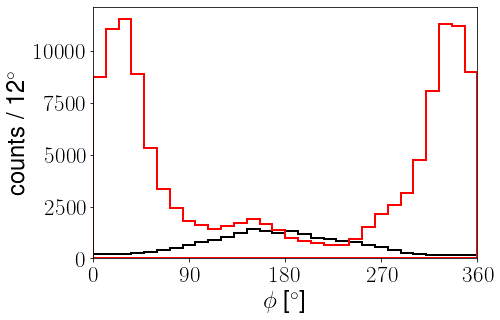

In [51]:
fig, ax = plt.subplots(1,1, figsize=(7.5,5))
dvcs = dvcsMCInb["dvcs"]
dvcs1 = dvcs[dvcs.Pstat<4000]
dvcs2 = dvcs[dvcs.Pstat>4000]
ax.hist(dvcs1.phi2, bins = np.linspace(0, 360, 31), linewidth = 2, histtype = 'stepfilled', facecolor = 'none', edgecolor = 'k')
ax.hist(dvcs2.phi2, bins = np.linspace(0, 360, 31), linewidth = 2, histtype = 'stepfilled', facecolor = 'none', edgecolor = 'r')
ax.set_xlabel(r"$\phi$" + " [" + degree +"]")
ax.set_xlim([0, 360])
ax.set_xticks([0, 90, 180, 270, 360])
ax.set_ylabel("counts / 12" + degree)
# ax[1].hist(dvcs1.t2/dvcs1.Q2, bins = np.linspace(0, 1, 101), linewidth = 2, histtype = 'stepfilled', facecolor = 'none', edgecolor = 'k')
# ax[1].hist(dvcs2.t2/dvcs2.Q2, bins = np.linspace(0, 1, 101), linewidth = 2, histtype = 'stepfilled', facecolor = 'none', edgecolor = 'r')
# ax[1].set_xlabel(r"$Q^{2}/(-t)$")
# ax[1].set_ylabel("counts/(0.01)")
plt.tight_layout()
plt.savefig("FDCD.pdf")

In [6]:
#Take Forward part only
dvcsContaminationInbSim = pi0MCdnpInb["df_epg"][pi0MCdnpInb["df_epg"]["Pstat"]<4000]
#Kinematic cuts that should be applied without regard to excl. cuts.
dvcsSim = dvcsContaminationInbSim
cut_xBupper = dvcsSim["xB"] < 1  # xB
cut_xBlower = dvcsSim["xB"] > 0  # xB
cut_Q2 = dvcsSim["Q2"] > 1  # Q2
cut_W = dvcsSim["W"] > 2  # W
cut_Ee = dvcsSim["Ee"] > 2  # Ee
cut_Ge = dvcsSim["Ge"] > 3  # Ge
cut_Pp = mag([dvcsSim["Ppx"], dvcsSim["Ppy"], dvcsSim["Ppz"]]) > 0.12  # Pp
dvcsSim = dvcsSim[cut_xBupper & cut_xBlower & cut_Q2 & cut_W & cut_Ee & cut_Ge & cut_Pp]
dvcsContaminationInbSim = dvcsSim[dvcsSim["nmg"]==1]

In [7]:
dvcsInbSim = dvcsMCInb["df_epg"][dvcsMCInb["df_epg"]["Pstat"]<4000]
#Kinematic cuts that should be applied without regard to excl. cuts.
dvcsSim = dvcsInbSim
cut_xBupper = dvcsSim["xB"] < 1  # xB
cut_xBlower = dvcsSim["xB"] > 0  # xB
cut_Q2 = dvcsSim["Q2"] > 1  # Q2
cut_W = dvcsSim["W"] > 2  # W
cut_Ee = dvcsSim["Ee"] > 2  # Ee
cut_Ge = dvcsSim["Ge"] > 3  # Ge
cut_Pp = mag([dvcsSim["Ppx"], dvcsSim["Ppy"], dvcsSim["Ppz"]]) > 0.12  # Pp
dvcsSim = dvcsSim[cut_xBupper & cut_xBlower & cut_Q2 & cut_W & cut_Ee & cut_Ge & cut_Pp]
dvcsInbSim = dvcsSim

In [16]:
#inbending!
varstoplot = ["coneAngle", "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_eg", "MM2_ep", "MPt"]
title = [r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{ep\gamma}$", "MM"+r"${}^{2}_{ep\gamma}$", "MM"+r"${}^{2}_{e\gamma}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{ep\gamma}$"]
unit = [degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [0, 0, 0, -2.5, -0.2, -1, -0.8 , 0]
binends = [50, 5, 30, 3.5, 0.2, 4, 0.8, 0.5]
fig, axs = plt.subplots(2, 4, figsize = (15,10))
for yind in range(0, 2):
	for xind in range(0,4):
		ind = 4*yind + xind
		start = binstarts[ind]
		end = binends[ind]
		bins = np.linspace(start, end, 51)
		axs[yind, xind].hist(dvcsInbSim[varstoplot[ind]], bins = bins, density = True, histtype='stepfilled', facecolor='none', edgecolor='b')
		axs[yind, xind].hist(dvcsContaminationInbSim[varstoplot[ind]], bins = bins, density = True, histtype='stepfilled', facecolor='none', edgecolor='r')
		axs[yind, xind].set_title(title[ind])
		axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
		axs[yind, xind].set_xlim([start, end])
axs[0,0].axvline(5, linestyle='--', color = 'k')
axs[0,0].set_xticks([0, 5, 25, 50])
axs[0,1].axvline(2.5, linestyle='--', color = 'k')
axs[0,2].axvline(25, linestyle='--', color = 'k')
axs[0,2].set_xticks([0, 5, 10, 15, 20, 25, 30])
axs[0,3].axvline(1.5, linestyle='--', color = 'k')
axs[0,3].axvline(-0.5, linestyle='--', color = 'k')
axs[0,3].set_xticks([-2.5, -0.5, 1.5, 3.5])
axs[1,0].axvline(0.1, linestyle='--', color = 'k')
axs[1,0].axvline(-0.1, linestyle='--', color = 'k')
axs[1,0].set_xticks([-0.2, -0.1, 0, 0.1, 0.2])
axs[1,1].axvline(0, linestyle='--', color = 'k')
axs[1,1].axvline(3, linestyle='--', color = 'k')
axs[1,1].set_xticks([-1, 0, 1, 2,3, 4])
axs[1,2].axvline(-0.4, linestyle='--', color = 'k')
axs[1,2].axvline(0.4, linestyle='--', color = 'k')
axs[1,2].set_xticks([-0.8, -0.4, 0, 0.4, 0.8])
axs[1,3].axvline(0.25, linestyle='--', color = 'k')
plt.tight_layout()
# plt.show()
plt.savefig("analysisnote/setting_excl_cuts.pdf")
plt.clf()

<Figure size 1080x720 with 0 Axes>

In [92]:
dvpi0 = pi0MCdnpInb["dvpi0"]
dvpi0 = dvpi0[dvpi0["Pstat"]<4000]
df_MC = pi0MCdnpInb["df_MC"]
gam1 = df_MC[df_MC.index%2==0]
gam1 = gam1.reset_index(drop=True)
gam2 = df_MC[df_MC.index%2==1]
gam2 = gam2.reset_index(drop=True)
gam1.loc[:,"MCGpx2"] = gam2.loc[:,"MCGpx"]
gam1.loc[:,"MCGpy2"] = gam2.loc[:,"MCGpy"]
gam1.loc[:,"MCGpz2"] = gam2.loc[:,"MCGpz"]
gam1.loc[:,"MCGe2"] = gam2.loc[:,"MCGe"]
df_MC = gam1
dvpi0 = pd.merge(dvpi0, df_MC, how="inner", on="event")
dvpi0copy = copy(dvpi0)
dvpi0copy.loc[:, "MCGe"] = np.where(dvpi0["MCGe"]>dvpi0["MCGe2"], dvpi0.loc[:, "MCGe"], dvpi0.loc[:, "MCGe2"])
dvpi0copy.loc[:, "MCGe2"] = np.where(dvpi0["MCGe"]>dvpi0["MCGe2"], dvpi0.loc[:, "MCGe2"], dvpi0.loc[:, "MCGe"])
dvpi0 = dvpi0copy
dvpi0["MCPp"] = mag([dvpi0["MCPpx"], dvpi0["MCPpy"], dvpi0["MCPpz"]])
dvpi0["Pp"] = mag([dvpi0["Ppx"], dvpi0["Ppy"], dvpi0["Ppz"]])
dvpi0["MCPpt"] = mag([dvpi0["MCPpx"], dvpi0["MCPpy"], 0])
dvpi0["Ppt"] = mag([dvpi0["Ppx"], dvpi0["Ppy"], 0])
dvpi01 = dvpi0[dvpi0.Ptheta<27]
dvpi02 = dvpi0[dvpi0.Ptheta>=27]
# dvpi02 = dvpi02[dvpi02["MCPp"]-dvpi02["Pp"]<0.1]
# dvpi02 = dvpi02[dvpi02["MCPp"]-dvpi02["Pp"]>-0.025]
# dvpi02 = dvpi02[np.abs(dvpi02["MCPp"]-dvpi02["Pp"]-correction(res_lsq, dvpi02["Pp"]))<0.02]

In [89]:
x0 = [0.1, -4]
for i in range (0, 100):
    res_lsq = least_squares(fun, x0, args=(dvpi01["Ppz"], dvpi01["MCPpz"]-dvpi01["Ppz"]))
    dvpi01 = dvpi01[np.abs(dvpi01["MCPpz"]-dvpi01["Ppz"]-correction(res_lsq, dvpi01["Ppz"]))<0.05]
print(res_lsq.x)

x0 = [0.12280133, -2.62]
for i in range (0, 100):
    res_lsq = least_squares(fun, x0, args=(dvpi02["Ppz"], dvpi02["MCPpz"]-dvpi02["Ppz"]))
    dvpi02 = dvpi02[np.abs(dvpi02["MCPpz"]-dvpi02["Ppz"]-correction(res_lsq, dvpi02["Ppz"]))<0.05]
print(res_lsq.x)

[ 0.03905658 -2.14597285]
[ 0.12507378 -2.62346876]


In [76]:
#     x0, x1 = res_lsq.x
#     return x0*np.exp(x1*t)
def correction(res_lsq, t):
    x0, x1 = res_lsq.x
    return x0*np.exp(x1*t)

In [77]:
def fun(x, t, y):
    return x[0]*np.exp(x[1]*t) - y
x0 = np.ones(2)
x0[1] = -4
res_lsq = least_squares(fun, x0, args=(dvpi01["Ppz"], (dvpi01["MCPpz"]-dvpi01["Ppz"])))

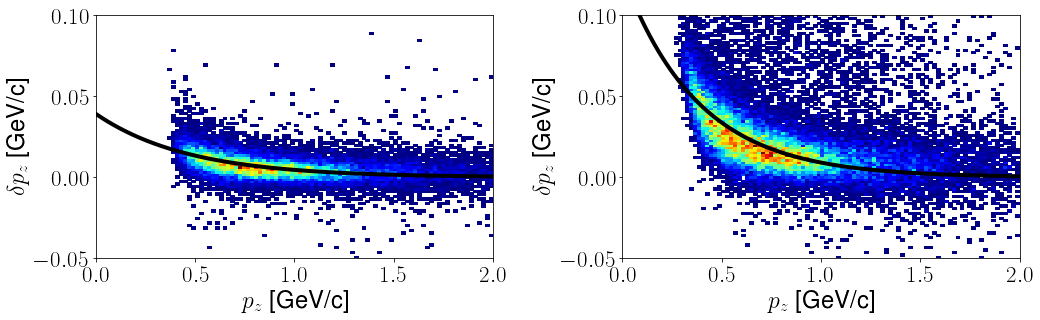

In [138]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist2d(dvpi01.Ppz, (dvpi01["MCPpz"]-dvpi01["Ppz"]), bins = [np.linspace(0,2, 101), np.linspace(-0.05 , 0.1, 101)], cmin = 1, cmap = cmap)
ax[0].plot(np.linspace(0, 2, 101), correction1(np.linspace(0, 2, 101)), color='k', linewidth=4)
ax[0].set_ylabel("$\delta p_z$"+ " [" + GeVc + "]")
ax[0].set_xlabel("$p_z$"+ " [" + GeVc + "]")

ax[1].hist2d(dvpi02.Ppz, (dvpi02["MCPpz"]-dvpi02["Ppz"]), bins = [np.linspace(0,2, 101), np.linspace(-0.05 , 0.1, 101)], cmin = 1, cmap = cmap)
ax[1].plot(np.linspace(0, 2, 101), correction2(np.linspace(0, 2, 101)), color='k', linewidth=4)
ax[1].set_ylabel("$\delta p_z$"+ " [" + GeVc + "]")
ax[1].set_xlabel("$p_z$"+ " [" + GeVc + "]")

plt.tight_layout()
# plt.show()
plt.savefig("correction_zmom.pdf")

In [90]:
def correction1(t):
    x0, x1 = [ 0.03905658, -2.14597285]
    return x0*np.exp(x1*t)

def correction2(t):
    x0, x1 = [ 0.12507378, -2.62346876]
    return x0*np.exp(x1*t)

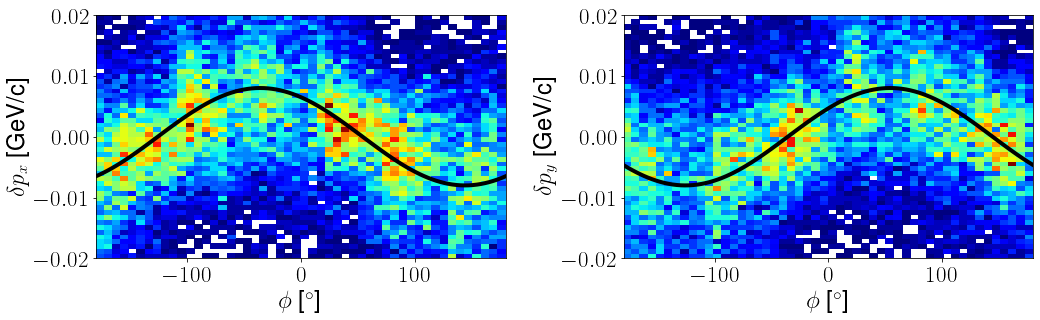

In [139]:
def correction3(t):
    x = [ 0.008,  2.1932]
    return x[0]*np.sin(t/180*np.pi+x[1])

def correction4(t):
    x = [0.008, 0.6224]
    return x[0]*np.sin(t/180*np.pi+x[1])

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist2d(dvpi02.Pphi, (dvpi02["MCPpx"]-dvpi02["Ppx"]), bins = [np.linspace(-180 , 180, 51), np.linspace(-0.02 , 0.02, 51)], cmin = 1, cmap = cmap)
ax[0].plot(np.linspace(-180, 180, 101), correction3(np.linspace(-180, 180, 101)), color='k', linewidth=4)
ax[0].set_ylabel("$\delta p_{x}$"+ " [" + GeVc + "]")
ax[0].set_xlabel("$\phi$"+ " [" + degree + "]")

ax[1].hist2d(dvpi02.Pphi, (dvpi02["MCPpy"]-dvpi02["Ppy"]), bins = [np.linspace(-180 , 180, 51), np.linspace(-0.02 , 0.02, 51)], cmin = 1, cmap = cmap)
ax[1].plot(np.linspace(-180, 180, 101), correction4(np.linspace(-180, 180, 101)), color='k', linewidth=4)
ax[1].set_ylabel("$\delta p_y$"+ " [" + GeVc + "]")
ax[1].set_xlabel("$\phi$"+ " [" + degree + "]")

plt.tight_layout()
# plt.show()
plt.savefig("correction_phi.pdf")

In [140]:
#whenever want to reload libraries
import importlib
import utils
importlib.reload(utils.epg)
from utils.epg import *

In [141]:
#pi0 simulation from Andrey, inb, rec
fname = "~/Dropbox (MIT)/data/MC/dnp/pi0DNPInbREC.root"
epg = epgFromROOT(fname, rec=True)
dvpi0 = epg.getDVpi0(correction=True)
dvcs = epg.getDVCS(correction=True, sub2g=False)
pi0MCdnpInb = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_ep": epg.df_ep, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg, "df_MC":epg.df_MC}

In [142]:
dvpi0 = pi0MCdnpInb["dvpi0"]
df_MC = pi0MCdnpInb["df_MC"]
gam1 = df_MC[df_MC.index%2==0]
gam1 = gam1.reset_index(drop=True)
gam2 = df_MC[df_MC.index%2==1]
gam2 = gam2.reset_index(drop=True)
gam1.loc[:,"MCGpx2"] = gam2.loc[:,"MCGpx"]
gam1.loc[:,"MCGpy2"] = gam2.loc[:,"MCGpy"]
gam1.loc[:,"MCGpz2"] = gam2.loc[:,"MCGpz"]
gam1.loc[:,"MCGe2"] = gam2.loc[:,"MCGe"]
df_MC = gam1
dvpi0 = pd.merge(dvpi0, df_MC, how="inner", on="event")
dvpi0copy = copy(dvpi0)
dvpi0copy.loc[:, "MCGe"] = np.where(dvpi0["MCGe"]>dvpi0["MCGe2"], dvpi0.loc[:, "MCGe"], dvpi0.loc[:, "MCGe2"])
dvpi0copy.loc[:, "MCGe2"] = np.where(dvpi0["MCGe"]>dvpi0["MCGe2"], dvpi0.loc[:, "MCGe2"], dvpi0.loc[:, "MCGe"])
dvpi0 = dvpi0copy
dvpi0["MCPp"] = mag([dvpi0["MCPpx"], dvpi0["MCPpy"], dvpi0["MCPpz"]])
dvpi0["Pp"] = mag([dvpi0["Ppx"], dvpi0["Ppy"], dvpi0["Ppz"]])
dvpi0["MCPpt"] = mag([dvpi0["MCPpx"], dvpi0["MCPpy"], 0])
dvpi0["Ppt"] = mag([dvpi0["Ppx"], dvpi0["Ppy"], 0])
dvpi01 = dvpi0[dvpi0.Ptheta<27]
dvpi02 = dvpi0[dvpi0.Ptheta>=27]
# dvpi02 = dvpi02[dvpi02["MCPp"]-dvpi02["Pp"]<0.1]
# dvpi02 = dvpi02[dvpi02["MCPp"]-dvpi02["Pp"]>-0.025]
# dvpi02 = dvpi02[np.abs(dvpi02["MCPp"]-dvpi02["Pp"]-correction(res_lsq, dvpi02["Pp"]))<0.02]

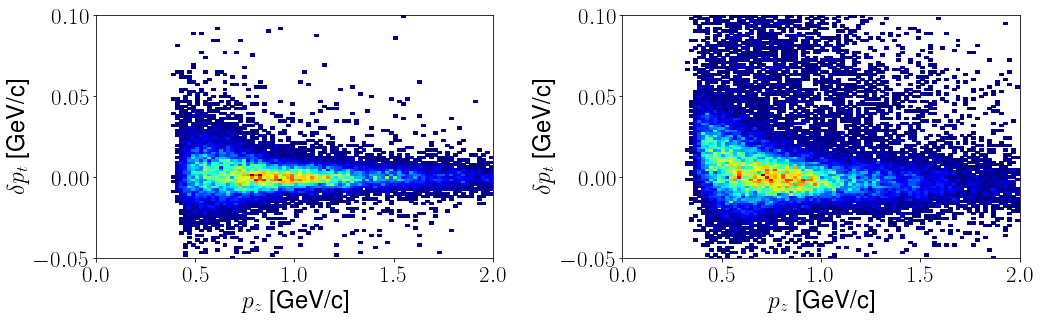

In [144]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist2d(dvpi01.Ppz, (dvpi01["MCPpt"]-dvpi01["Ppt"]), bins = [np.linspace(0,2, 101), np.linspace(-0.05 , 0.1, 101)], cmin = 1, cmap = cmap)
# ax[0].plot(np.linspace(0, 2, 101), correction1(np.linspace(0, 2, 101)), color='k', linewidth=4)
ax[0].set_ylabel("$\delta p_t$"+ " [" + GeVc + "]")
ax[0].set_xlabel("$p_z$"+ " [" + GeVc + "]")

ax[1].hist2d(dvpi02.Ppz, (dvpi02["MCPpt"]-dvpi02["Ppt"]), bins = [np.linspace(0,2, 101), np.linspace(-0.05 , 0.1, 101)], cmin = 1, cmap = cmap)
# ax[1].plot(np.linspace(0, 2, 101), correction2(np.linspace(0, 2, 101)), color='k', linewidth=4)
ax[1].set_ylabel("$\delta p_t$"+ " [" + GeVc + "]")
ax[1].set_xlabel("$p_z$"+ " [" + GeVc + "]")

plt.tight_layout()
# plt.show()
plt.savefig("correction_pt.pdf")

In [102]:
#whenever want to reload libraries
import importlib
import utils
importlib.reload(utils.epg)
from utils.epg import *

In [103]:
#pi0 simulation from Andrey, inb, rec
fname = "~/Dropbox (MIT)/data/MC/dnp/pi0DNPInbREC.root"
epg = epgFromROOT(fname, rec=True)
dvpi0 = epg.getDVpi0(correction=True)
dvcs = epg.getDVCS(correction=True, sub2g=False)
pi0MCdnpInb = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_ep": epg.df_ep, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg, "df_MC":epg.df_MC}

In [104]:
dvpi0 = pi0MCdnpInb["dvpi0"]
df_MC = pi0MCdnpInb["df_MC"]
gam1 = df_MC[df_MC.index%2==0]
gam1 = gam1.reset_index(drop=True)
gam2 = df_MC[df_MC.index%2==1]
gam2 = gam2.reset_index(drop=True)
gam1.loc[:,"MCGpx2"] = gam2.loc[:,"MCGpx"]
gam1.loc[:,"MCGpy2"] = gam2.loc[:,"MCGpy"]
gam1.loc[:,"MCGpz2"] = gam2.loc[:,"MCGpz"]
gam1.loc[:,"MCGe2"] = gam2.loc[:,"MCGe"]
df_MC = gam1
dvpi0 = pd.merge(dvpi0, df_MC, how="inner", on="event")
dvpi0copy = copy(dvpi0)
dvpi0copy.loc[:, "MCGe"] = np.where(dvpi0["MCGe"]>dvpi0["MCGe2"], dvpi0.loc[:, "MCGe"], dvpi0.loc[:, "MCGe2"])
dvpi0copy.loc[:, "MCGe2"] = np.where(dvpi0["MCGe"]>dvpi0["MCGe2"], dvpi0.loc[:, "MCGe2"], dvpi0.loc[:, "MCGe"])
dvpi0 = dvpi0copy
dvpi0["MCPp"] = mag([dvpi0["MCPpx"], dvpi0["MCPpy"], dvpi0["MCPpz"]])
dvpi0["Pp"] = mag([dvpi0["Ppx"], dvpi0["Ppy"], dvpi0["Ppz"]])
dvpi0["MCPpt"] = mag([dvpi0["MCPpx"], dvpi0["MCPpy"], 0])
dvpi0["Ppt"] = mag([dvpi0["Ppx"], dvpi0["Ppy"], 0])
dvpi01 = dvpi0[dvpi0.Ptheta<27]
dvpi02 = dvpi0[dvpi0.Ptheta>=27]
# dvpi02 = dvpi02[dvpi02["MCPp"]-dvpi02["Pp"]<0.1]
# dvpi02 = dvpi02[dvpi02["MCPp"]-dvpi02["Pp"]>-0.025]
# dvpi02 = dvpi02[np.abs(dvpi02["MCPp"]-dvpi02["Pp"]-correction(res_lsq, dvpi02["Pp"]))<0.02]

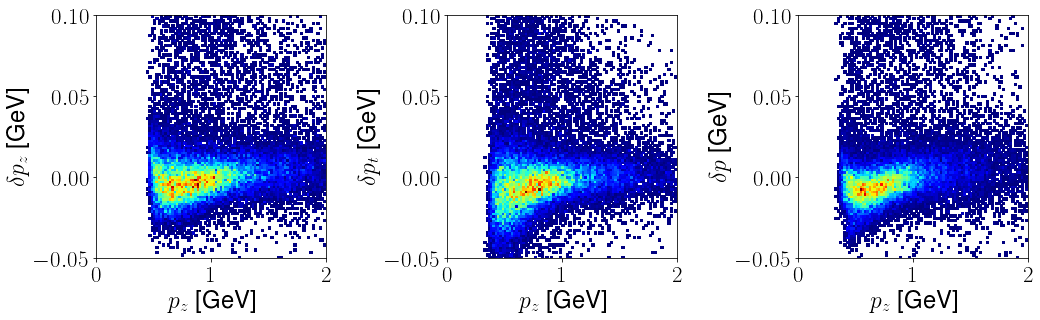

In [114]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].hist2d(dvpi02.Pp, dvpi02.MCPpz-dvpi02.Ppz, bins = [np.linspace(0,2, 101), np.linspace(-0.05, 0.1, 101)], cmin = 1, cmap = cmap)
ax[0].set_ylabel("$\delta p_z$"+ " [" + GeVc + "]")
ax[0].set_xlabel("$p_z$"+ " [" + GeVc + "]")
ax[1].hist2d(dvpi02.Ppz, dvpi02.MCPpt- dvpi02.Ppt , bins = [np.linspace(0, 2, 101), np.linspace(-.05, .1, 101)], cmin = 1, cmap = cmap)
ax[1].set_ylabel("$\delta p_t$"+ " [" + GeVc + "]")
ax[1].set_xlabel("$p_z$"+ " [" + GeVc + "]")
ax[2].hist2d(dvpi02.Ppz,  dvpi02.MCPp - dvpi02.Pp, bins = [np.linspace(0, 2, 101), np.linspace(-.05, .1, 101)], cmin = 1, cmap = cmap)
ax[2].set_ylabel("$\delta p$"+ " [" + GeVc + "]")
ax[2].set_xlabel("$p_z$"+ " [" + GeVc + "]")
plt.tight_layout()
plt.savefig("correction_result2.pdf")

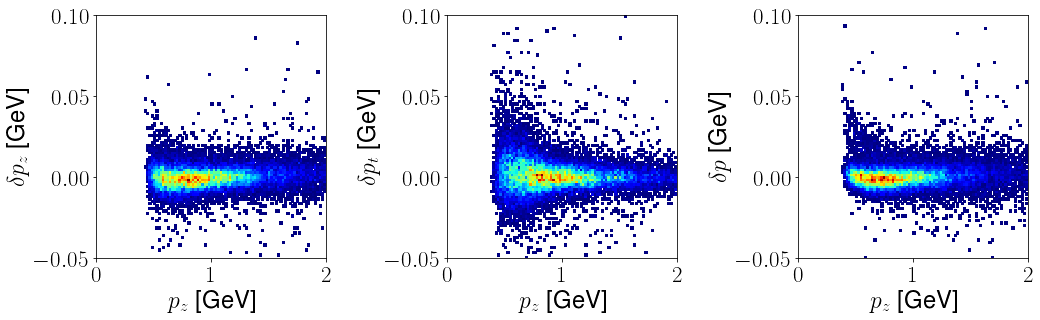

In [115]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].hist2d(dvpi01.Pp, dvpi01.MCPpz-dvpi01.Ppz, bins = [np.linspace(0,2, 101), np.linspace(-0.05, 0.1, 101)], cmin = 1, cmap = cmap)
ax[0].set_ylabel("$\delta p_z$"+ " [" + GeVc + "]")
ax[0].set_xlabel("$p_z$"+ " [" + GeV + "]")
ax[1].hist2d(dvpi01.Ppz, dvpi01.MCPpt- dvpi01.Ppt , bins = [np.linspace(0, 2, 101), np.linspace(-.05, .1, 101)], cmin = 1, cmap = cmap)
ax[1].set_ylabel("$\delta p_t$"+ " [" + GeVc + "]")
ax[1].set_xlabel("$p_z$"+ " [" + GeV + "]")
ax[2].hist2d(dvpi01.Ppz,  dvpi01.MCPp - dvpi01.Pp, bins = [np.linspace(0, 2, 101), np.linspace(-.05, .1, 101)], cmin = 1, cmap = cmap)
ax[2].set_ylabel("$\delta p$"+ " [" + GeVc + "]")
ax[2].set_xlabel("$p_z$"+ " [" + GeVc + "]")
plt.tight_layout()
plt.savefig("correction_result1.pdf")

In [116]:
#pi0 simulation from Andrey, inb, rec
fname = "~/Dropbox (MIT)/data/MC/dnp/pi0DNPInbREC.root"
epg = epgFromROOT(fname, rec=True)
dvpi0 = epg.getDVpi0(correction=False)
dvcs = epg.getDVCS(correction=False, sub2g=False)
pi0MCdnpInb = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_ep": epg.df_ep, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg, "df_MC":epg.df_MC}

In [129]:
dvpi0 = pi0MCdnpInb["dvpi0"]
# dvpi0 = dvpi0[dvpi0.Pp<1]
pro = [dvpi0.loc[:, "Ppx"], dvpi0.loc[:, "Ppy"], dvpi0.loc[:, "Ppz"]]
dvpi0.loc[:, "Pp"] = mag(pro)
num = (0.1349768)**2 - dvpi0.MM2_ep
A0 = dvpi0.Ee + dvpi0.Pe - ebeam - M
A3 = dvpi0.Epz + dvpi0.Ppz - pbeam
vecA = [dvpi0["Epx"] + dvpi0["Ppx"], dvpi0["Epy"] + dvpi0["Ppy"], dvpi0["Epz"] + dvpi0["Ppz"] - pbeam]
den = 2*(A0*dvpi0.Ppz/dvpi0.Pe - A3)
# den = 2 * A0 * dvpi0.Pp / dvpi0.Pe - 2 * A3
dvpi0.loc[:, "Pcorrection"] = num/den
df_MC = pi0MCdnpInb["df_MC"]
gam1 = df_MC[df_MC.index%2==0]
gam1 = gam1.reset_index(drop=True)
gam2 = df_MC[df_MC.index%2==1]
gam2 = gam2.reset_index(drop=True)
gam1.loc[:,"MCGpx2"] = gam2.loc[:,"MCGpx"]
gam1.loc[:,"MCGpy2"] = gam2.loc[:,"MCGpy"]
gam1.loc[:,"MCGpz2"] = gam2.loc[:,"MCGpz"]
gam1.loc[:,"MCGe2"] = gam2.loc[:,"MCGe"]
df_MC = gam1
dvpi0 = pd.merge(dvpi0, df_MC, how="inner", on="event")
dvpi0copy = copy(dvpi0)
dvpi0copy.loc[:, "MCGe"] = np.where(dvpi0["MCGe"]>dvpi0["MCGe2"], dvpi0.loc[:, "MCGe"], dvpi0.loc[:, "MCGe2"])
dvpi0copy.loc[:, "MCGe2"] = np.where(dvpi0["MCGe"]>dvpi0["MCGe2"], dvpi0.loc[:, "MCGe2"], dvpi0.loc[:, "MCGe"])
dvpi0 = dvpi0copy
dvpi0["MCPp"] = mag([dvpi0["MCPpx"], dvpi0["MCPpy"], dvpi0["MCPpz"]])
dvpi01 = dvpi0[dvpi0.Ptheta<27]
dvpi02 = dvpi0[dvpi0.Ptheta>=27]

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


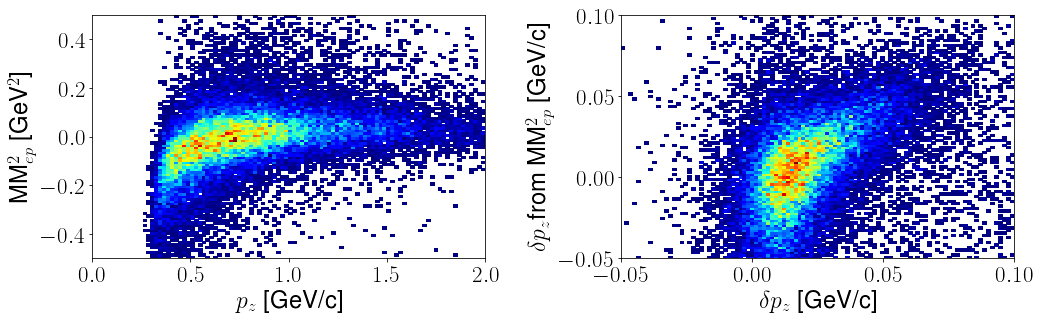

In [137]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist2d(dvpi02.Ppz, dvpi02.MM2_ep, bins = [np.linspace(0,2, 101), np.linspace(-0.5, 0.5, 101)], cmin = 1, cmap = cmap)
ax[0].set_ylabel("MM"+r"${}^{2}_{ep}$"+ " [" + GeV2 + "]")
ax[0].set_xlabel("$p_z$"+ " [" + GeVc + "]")
# ax[1].hist2d(dvpi01.Ppz, dvpi01.MCPpt- dvpi01.Ppt , bins = [np.linspace(0, 2, 101), np.linspace(-.05, .1, 101)], cmin = 1, cmap = cmap)
ax[1].hist2d((dvpi02["MCPpz"]-dvpi02["Ppz"]), dvpi02.Pcorrection, bins = [np.linspace(-0.05 , 0.1, 101), np.linspace(-0.05 , 0.1, 101)], cmin = 1, cmap = cmap)
ax[1].set_ylabel("$\delta p_z$"+"from " +"MM"+r"${}^{2}_{ep}$" + " [" + GeVc + "]")
ax[1].set_xlabel("$\delta p_z$"+ " [" + GeVc + "]")
plt.tight_layout()
# plt.show()
plt.savefig("correlation.pdf")

In [145]:
#pi0 from experiment, inbending
fname = "~/Dropbox (MIT)/data/data/pi0_inb.root"
epg = epgFromROOT(fname)
dvpi0 = epg.getDVpi0(correction=False)
dvcs = epg.getDVCS(correction=False, sub2g=False)
pi0ExpInb = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg}

In [155]:
dvpi0 = pi0ExpInb["dvpi0"]
# dvpi0 = dvpi0[dvpi0.Pp<1]
pro = [dvpi0.loc[:, "Ppx"], dvpi0.loc[:, "Ppy"], dvpi0.loc[:, "Ppz"]]
dvpi0.loc[:, "Pp"] = mag(pro)
num = (0.1349768)**2 - dvpi0.MM2_ep
A0 = dvpi0.Ee + dvpi0.Pe - ebeam - M
A3 = dvpi0.Epz + dvpi0.Ppz - pbeam
vecA = [dvpi0["Epx"] + dvpi0["Ppx"], dvpi0["Epy"] + dvpi0["Ppy"], dvpi0["Epz"] + dvpi0["Ppz"] - pbeam]
den = 2*(A0*dvpi0.Ppz/dvpi0.Pe - A3)
# den = 2 * A0 * dvpi0.Pp / dvpi0.Pe - 2 * A3
dvpi0.loc[:, "Pcorrection"] = num/den
df_MC = pi0MCdnpInb["df_MC"]
gam1 = df_MC[df_MC.index%2==0]
gam1 = gam1.reset_index(drop=True)
gam2 = df_MC[df_MC.index%2==1]
gam2 = gam2.reset_index(drop=True)
gam1.loc[:,"MCGpx2"] = gam2.loc[:,"MCGpx"]
gam1.loc[:,"MCGpy2"] = gam2.loc[:,"MCGpy"]
gam1.loc[:,"MCGpz2"] = gam2.loc[:,"MCGpz"]
gam1.loc[:,"MCGe2"] = gam2.loc[:,"MCGe"]
df_MC = gam1
dvpi0 = pd.merge(dvpi0, df_MC, how="inner", on="event")
dvpi0copy = copy(dvpi0)
dvpi0copy.loc[:, "MCGe"] = np.where(dvpi0["MCGe"]>dvpi0["MCGe2"], dvpi0.loc[:, "MCGe"], dvpi0.loc[:, "MCGe2"])
dvpi0copy.loc[:, "MCGe2"] = np.where(dvpi0["MCGe"]>dvpi0["MCGe2"], dvpi0.loc[:, "MCGe2"], dvpi0.loc[:, "MCGe"])
dvpi0 = dvpi0copy
dvpi0["MCPp"] = mag([dvpi0["MCPpx"], dvpi0["MCPpy"], dvpi0["MCPpz"]])
dvpi01 = dvpi0[dvpi0.Ptheta<27]
dvpi02 = dvpi0[dvpi0.Ptheta>=27]

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [161]:
def correction5(t):
    return 0.28674313 * np.exp(-5.52191624*t)


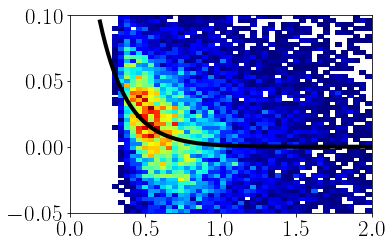

In [162]:
plt.hist2d(dvpi02.Ppz, dvpi02.Pcorrection, bins = [np.linspace(0,2, 51), np.linspace(-0.05 , 0.1, 51)], cmin = 1, cmap = cmap)
# plt.hist2d(dvpi02.Ppz, dvpi02.MCPpz - dvpi02.Ppz, bins = [np.linspace(0,2, 51), np.linspace(-0.05 , 0.1, 51)], cmin = 1, cmap = cmap)
plt.plot(np.linspace(0.2, 2, 101), correction5(np.linspace(0.2, 2, 101)), color='k', linewidth=4)
# plt.plot(np.linspace(0.2, 2, 101), correction2(np.linspace(0.2, 2, 101)), color='r', linewidth=4)
plt.tight_layout()
plt.show()


In [149]:
#pi0 simulation from Andrey, inb, rec
fname = "~/Dropbox (MIT)/data/MC/dnp/pi0DNPInbREC.root"
epg = epgFromROOT(fname, rec=True)
dvpi0 = epg.getDVpi0(correction=True)
dvcs = epg.getDVCS(correction=True, sub2g=False)
pi0MCdnpInbCorrected = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_ep": epg.df_ep, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg, "df_MC":epg.df_MC}

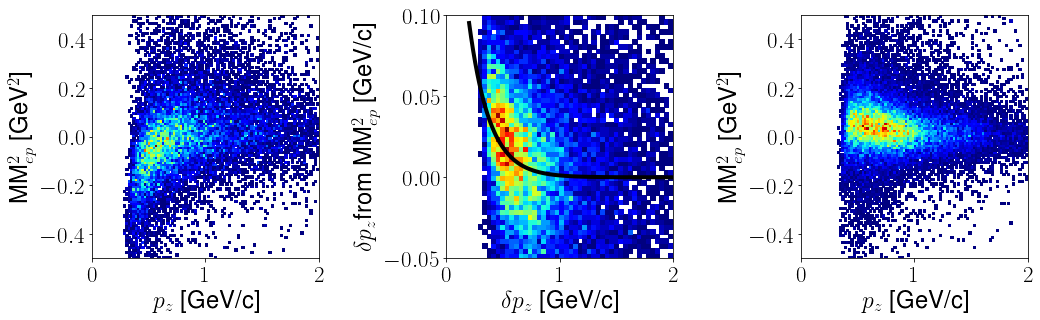

In [166]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].hist2d(dvpi02.Ppz, dvpi02.MM2_ep, bins = [np.linspace(0,2, 101), np.linspace(-0.5, 0.5, 101)], cmin = 1, cmap = cmap)
ax[0].set_ylabel("MM"+r"${}^{2}_{ep}$"+ " [" + GeV2 + "]")
ax[0].set_xlabel("$p_z$"+ " [" + GeVc + "]")
# ax[1].hist2d(dvpi01.Ppz, dvpi01.MCPpt- dvpi01.Ppt , bins = [np.linspace(0, 2, 101), np.linspace(-.05, .1, 101)], cmin = 1, cmap = cmap)
ax[1].hist2d(dvpi02.Ppz, dvpi02.Pcorrection, bins = [np.linspace(0,2, 51), np.linspace(-0.05 , 0.1, 51)], cmin = 1, cmap = cmap)
ax[1].plot(np.linspace(0.2, 2, 101), correction5(np.linspace(0.2, 2, 101)), color='k', linewidth=4)
ax[1].set_ylabel("$\delta p_z$"+"from " +"MM"+r"${}^{2}_{ep}$" + " [" + GeVc + "]")
ax[1].set_xlabel("$\delta p_z$"+ " [" + GeVc + "]")

dvpi03 = pi0MCdnpInbCorrected["dvpi0"]
dvpi03 = dvpi03[dvpi03["Ptheta"]>27]
ax[2].hist2d(dvpi03.Ppz, dvpi03.MM2_ep, bins = [np.linspace(0,2, 101), np.linspace(-0.5, 0.5, 101)], cmin = 1, cmap = cmap)
ax[2].set_ylabel("MM"+r"${}^{2}_{ep}$"+ " [" + GeV2 + "]")
ax[2].set_xlabel("$p_z$"+ " [" + GeVc + "]")


plt.tight_layout()
# plt.show()
plt.savefig("correction_exp.pdf")

In [167]:
#whenever want to reload libraries
import importlib
import utils
importlib.reload(utils.epg)
from utils.epg import *

In [169]:
#pi0 simulation from Andrey, inb, rec
fname = "~/Dropbox (MIT)/data/MC/dnp/pi0DNPInbREC.root"
epg = epgFromROOT(fname, rec=True)
dvpi0 = epg.getDVpi0(correction=True)
dvcs = epg.getDVCS(correction=True, sub2g=False)
pi0MCdnpInbCorrected = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_ep": epg.df_ep, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg, "df_MC":epg.df_MC}

In [170]:
#dvcs from simulation, vz correct, vxvy (0, 0), rec
fname = "~/Dropbox (MIT)/data/MC/nonradVzCorrInbREC.root"
epg = epgFromROOT(fname, rec=True)
dvpi0 = epg.getDVpi0(correction=True)
dvcs = epg.getDVCS(correction=True, sub2g=False)
dvcsMCInbCorrected = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg, "df_MC": epg.df_MC}

In [171]:
#pi0 from experiment, inbending
fname = "~/Dropbox (MIT)/data/data/pi0_inb.root"
epg = epgFromROOT(fname)
dvpi0 = epg.getDVpi0(correction=True)
dvcs = epg.getDVCS(correction=True, sub2g=False)
pi0ExpInbProtonCorrected = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg}

In [172]:
#pi0 from experiment, inbending
fname = "~/Dropbox (MIT)/data/data/dvcs_inb.root"
epg = epgFromROOT(fname)
dvpi0 = epg.getDVpi0(correction=True)
dvcs = epg.getDVCS(correction=True, sub2g=False)
dvcsExpInbProtonCorrected = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg}

In [174]:
#pi0 from experiment, inbending
fname = "~/Dropbox (MIT)/data/data/pi0_inb.root"
epg = epgFromROOT(fname)
dvpi0 = epg.getDVpi0(correction=False)
dvcs = epg.getDVCS(correction=False, sub2g=False)
pi0ExpInb = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg}

In [175]:
#pi0 from experiment, inbending
fname = "~/Dropbox (MIT)/data/data/dvcs_inb.root"
epg = epgFromROOT(fname)
dvpi0 = epg.getDVpi0(correction=False)
dvcs = epg.getDVCS(correction=False, sub2g=False)
dvcsExpInb = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg}

In [180]:
dvpi0Indvpi0Sim = pi0MCdnpInbCorrected["dvpi0"]
alldvcsIndvpi0Sim = pi0MCdnpInbCorrected["dvcs"]
onlydvcsIndvpi0Sim = alldvcsIndvpi0Sim[~alldvcsIndvpi0Sim["event"].isin(dvpi0Indvpi0Sim["event"])]
alldvcsIndata = dvcsExpInb["dvcs"]
# alldvcsIndata = dvcsExpInbProtonCorrected["dvcs"]
onlydvcsIndata = alldvcsIndata[~alldvcsIndata["event"].isin(dvcsExpInb["dvpi0"]["event"])]
dvpi0Indata = pi0ExpInb["dvpi0"]
# dvpi0Indata = pi0ExpInbProtonCorrected["dvpi0"]
onlydvcsIndvcsSim = dvcsMCInbCorrected["dvcs"] 

# onlydvcsIndata = onlydvcsIndata[onlydvcsIndata["t2"]<1.7]
# dvpi0Indata.loc[:,'t'] = 2 * M * (dvpi0Indata['Pe'] - M)
# dvpi0Indata = dvpi0Indata[dvpi0Indata["t"]<1.7]
# onlydvcsIndvpi0Sim = onlydvcsIndvpi0Sim[onlydvcsIndvpi0Sim["t2"]<1.7]

print(len(onlydvcsIndata["event"].unique()), len(dvpi0Indata["event"].unique()), len(dvpi0Indata["event"].unique())* len(onlydvcsIndvpi0Sim["event"].unique())/len(dvpi0Indvpi0Sim["event"].unique()))
cont_inb = len(dvpi0Indata["event"].unique())* len(onlydvcsIndvpi0Sim["event"].unique())/len(dvpi0Indvpi0Sim["event"].unique())/len(onlydvcsIndata["event"].unique())
print("the number of dvcs candidates in inbending: ", len(onlydvcsIndata["event"].unique())*(1-cont_inb))



99858 132748 39296.42636543022
the number of dvcs candidates in inbending:  60561.57363456977


In [187]:
varstoplot = ["coneAngle", "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_eg", "MM2_ep", "MPt"]
title = [r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{epg}$"]
unit = [degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [20, 0, 0, -0.5, -0.04, 0.1,-0.4 , 0]
binends = [60, 1.1, 10, 1.2, 0.04, 1.7, 0.4, 0.12]
fig, axs = plt.subplots(2, 4, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,4):
        ind = 4*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 51)
        simDist_dvpi0, bins = np.histogram(onlydvcsIndvpi0Sim[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(onlydvcsIndvcsSim[varstoplot[ind]], bins, density = True)
        simDist = cont_inb*simDist_dvpi0 + (1-cont_inb)*simDist_dvcs
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        cont_inb = 0
        axs[yind, xind].step(bincenters, cont_inb*simDist_dvpi0 + (1-cont_inb)*simDist_dvcs, where='mid',color='b', linewidth=1)
        cont_inb = 0.5
        axs[yind, xind].step(bincenters, cont_inb*simDist_dvpi0 + (1-cont_inb)*simDist_dvcs, where='mid',color='g', linewidth=1)
        cont_inb = 1
        axs[yind, xind].step(bincenters, cont_inb*simDist_dvpi0 + (1-cont_inb)*simDist_dvcs, where='mid',color='r', linewidth=1)

        axs[yind, xind].hist(onlydvcsIndata[varstoplot[ind]], bins = bins, density = True, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=4)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
plt.tight_layout()
# plt.show()
plt.savefig("dist_epg.pdf")
plt.clf()

<Figure size 1080x720 with 0 Axes>

In [192]:
onlydvcsIndvcsSim = dvcsMCInbCorrected["dvcs"] 
# onlydvcsIndvcsSim = onlydvcsIndvcsSim[onlydvcsIndvcsSim["t2"]<1.7]

varstoplot = ["nu", "W", "Q2", "xB", "t2", "phi2"]
title = [r"$\nu$", r"$W$", r"$Q^{2}$", r"$x_{B}$", r"$-t$", r"$\phi_{trento}$" ]
unit = [GeV, GeV, GeVc2, None, GeV2, degree]
binstarts = [0, 2, 0, 0, 0, 0]
binends = [10, 4, 10, 1, 1.7, 360]
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
for xind in range(0,3):
    for yind in range(0, 2):
        ind =xind+3*yind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 51)
        simDist_dvpi0, bins = np.histogram(onlydvcsIndvpi0Sim[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(onlydvcsIndvcsSim[varstoplot[ind]], bins, density = True)
        simDist = cont_inb*simDist_dvpi0 + (1-cont_inb)*simDist_dvcs
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
        cont_inb = 0
        axs[yind, xind].step(bincenters, cont_inb*simDist_dvpi0 + (1-cont_inb)*simDist_dvcs, where='mid',color='b', linewidth=1)
        cont_inb = 0.5
        axs[yind, xind].step(bincenters, cont_inb*simDist_dvpi0 + (1-cont_inb)*simDist_dvcs, where='mid',color='g', linewidth=1)
        cont_inb = 1
        axs[yind, xind].step(bincenters, cont_inb*simDist_dvpi0 + (1-cont_inb)*simDist_dvcs, where='mid',color='r', linewidth=1)

        axs[yind, xind].hist(onlydvcsIndata[varstoplot[ind]], bins = bins, density = True, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=4)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
axs[-1, -1].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.show()
plt.savefig("dist_eg.pdf")
plt.clf()

<Figure size 1080x720 with 0 Axes>

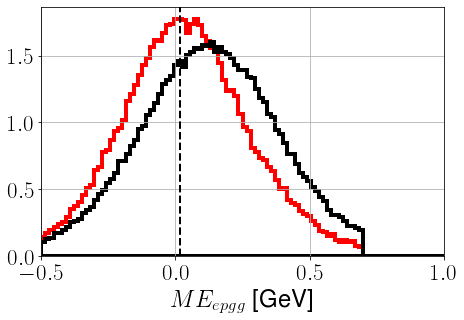

In [208]:
fig, axs = plt.subplots(1, 1, figsize = (7, 5))
dvpi0 = pi0ExpInb["dvpi0"]
dvpi0Indvpi0Sim.ME_epgg.hist(ax=axs,bins =np.linspace(-0.5, 1, 101), density = True, histtype='stepfilled', facecolor='none', edgecolor='r', linewidth=4)
dvpi0.ME_epgg.hist(ax=axs, bins =np.linspace(-0.5, 1, 101), density = True, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=4)
axs.axvline(0.135**2, color = 'k', linestyle = '--', linewidth = 2)
axs.set_xlim([-0.5, 1])
axs.set_xticks([-0.5, 0, 0.5, 1])
axs.set_xlabel(r"$ME_{epgg}$"+" ["+GeV+"]")
plt.tight_layout()
plt.savefig("shiftsinmissingenergyepgg.pdf")

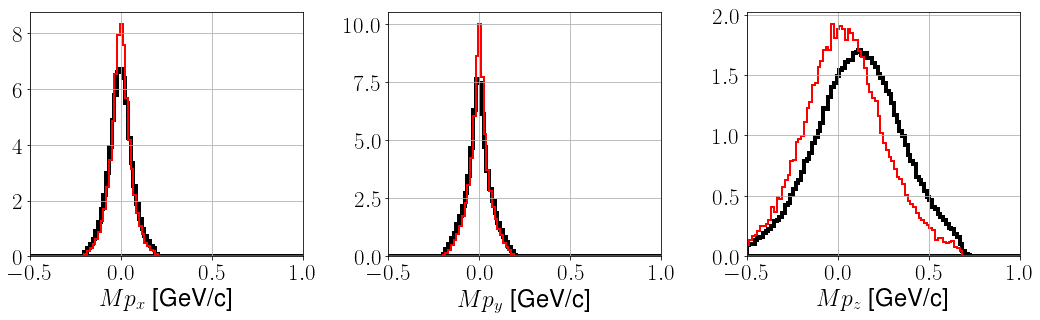

In [218]:
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].set_xlabel("$Mp_x$"+ " [" + GeVc + "]")
axs[1].set_xlabel("$Mp_y$"+ " [" + GeVc + "]")
axs[2].set_xlabel("$Mp_z$"+ " [" + GeVc + "]")
dvpi0.Mpx.hist(ax=axs[0], bins =np.linspace(-0.5, 1, 101), density = True, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=4)
dvpi0.Mpy.hist(ax=axs[1], bins =np.linspace(-0.5, 1, 101), density = True, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=4)
dvpi0.Mpz.hist(ax=axs[2], bins =np.linspace(-0.5, 1, 101), density = True, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=4)

dvpi0Indvpi0Sim.Mpx.hist(ax=axs[0], bins =np.linspace(-0.5, 1, 101), density = True, histtype='stepfilled', facecolor='none', edgecolor='r', linewidth=2)
dvpi0Indvpi0Sim.Mpy.hist(ax=axs[1], bins =np.linspace(-0.5, 1, 101), density = True, histtype='stepfilled', facecolor='none', edgecolor='r', linewidth=2)
dvpi0Indvpi0Sim.Mpz.hist(ax=axs[2], bins =np.linspace(-0.5, 1, 101), density = True, histtype='stepfilled', facecolor='none', edgecolor='r', linewidth=2)

for ax in axs:
    ax.set_xlim([-0.5, 1.0])
plt.tight_layout()
plt.savefig("hints_mom_corr.pdf")

In [262]:
#whenever want to reload libraries
import importlib
import utils
importlib.reload(utils.epg)
from utils.epg import *

In [263]:
#pi0 from experiment, inbending
fname = "~/Dropbox (MIT)/data/data/pi0_inb.root"
epg = epgFromROOT(fname)
dvpi0 = epg.getDVpi0(correction=True)
dvcs = epg.getDVCS(correction=True, sub2g=False)
pi0ExpInbAllCorrected = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg}

In [5]:
#pi0 from experiment, inbending
fname = "~/Dropbox (MIT)/data/data/dvcs_inb.root"
epg = epgFromROOT(fname)
dvpi0 = epg.getDVpi0(correction=True)
dvcs = epg.getDVCS(correction=True, sub2g=False)
dvcsExpInbAllCorrected = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg}

<AxesSubplot:>

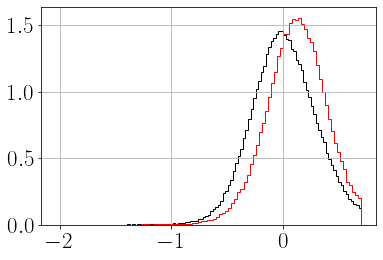

In [269]:
pi0ExpInbAllCorrected["dvpi0"].ME_epgg.hist(bins = 101, density=True, histtype='stepfilled', facecolor='none', edgecolor='k')
pi0ExpInbProtonCorrected["dvpi0"].ME_epgg.hist(bins=101, density=True, histtype='stepfilled', facecolor='none', edgecolor='r')

In [280]:
dvpi0Indvpi0Sim = pi0MCdnpInbCorrected["dvpi0"]
alldvcsIndvpi0Sim = pi0MCdnpInbCorrected["dvcs"]
onlydvcsIndvpi0Sim = alldvcsIndvpi0Sim[~alldvcsIndvpi0Sim["event"].isin(dvpi0Indvpi0Sim["event"])]
# alldvcsIndata = dvcsExpInb["dvcs"]
alldvcsIndata = dvcsExpInbAllCorrected["dvcs"]
onlydvcsIndata = alldvcsIndata[~alldvcsIndata["event"].isin(dvcsExpInb["dvpi0"]["event"])]
# dvpi0Indata = pi0ExpInb["dvpi0"]
dvpi0Indata = pi0ExpInbAllCorrected["dvpi0"]
onlydvcsIndvcsSim = dvcsMCInbCorrected["dvcs"] 

# onlydvcsIndata = onlydvcsIndata[onlydvcsIndata["t2"]<1.7]
# dvpi0Indata.loc[:,'t'] = 2 * M * (dvpi0Indata['Pe'] - M)
# dvpi0Indata = dvpi0Indata[dvpi0Indata["t"]<1.7]
# onlydvcsIndvpi0Sim = onlydvcsIndvpi0Sim[onlydvcsIndvpi0Sim["t2"]<1.7]

print(len(onlydvcsIndata["event"].unique()), len(dvpi0Indata["event"].unique()), len(dvpi0Indata["event"].unique())* len(onlydvcsIndvpi0Sim["event"].unique())/len(dvpi0Indvpi0Sim["event"].unique()))
cont_inb = len(dvpi0Indata["event"].unique())* len(onlydvcsIndvpi0Sim["event"].unique())/len(dvpi0Indvpi0Sim["event"].unique())/len(onlydvcsIndata["event"].unique())
print("the number of dvcs candidates in inbending: ", len(onlydvcsIndata["event"].unique())*(1-cont_inb))



111613 134783 39898.83263636199
the number of dvcs candidates in inbending:  71714.167363638


In [281]:
cont_inb

0.35747478014534145

In [282]:
onlydvcsIndvcsSim = dvcsMCInbCorrected["dvcs"] 
# onlydvcsIndvcsSim = onlydvcsIndvcsSim[onlydvcsIndvcsSim["t2"]<1.7]

varstoplot = ["nu", "W", "Q2", "xB", "t2", "phi2"]
title = [r"$\nu$", r"$W$", r"$Q^{2}$", r"$x_{B}$", r"$-t$", r"$\phi_{trento}$" ]
unit = [GeV, GeV, GeVc2, None, GeV2, degree]
binstarts = [0, 2, 0, 0, 0, 0]
binends = [10, 4, 10, 1, 1.7, 360]
fig, axs = plt.subplots(2, 3, figsize = (15, 10))
for xind in range(0,3):
    for yind in range(0, 2):
        ind =xind+3*yind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 51)
        simDist_dvpi0, bins = np.histogram(onlydvcsIndvpi0Sim[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(onlydvcsIndvcsSim[varstoplot[ind]], bins, density = True)
        simDist = cont_inb*simDist_dvpi0 + (1-cont_inb)*simDist_dvcs
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
#         cont_inb = 0
#         axs[yind, xind].step(bincenters, cont_inb*simDist_dvpi0 + (1-cont_inb)*simDist_dvcs, where='mid',color='b', linewidth=1)
#         cont_inb = 0.5
#         axs[yind, xind].step(bincenters, cont_inb*simDist_dvpi0 + (1-cont_inb)*simDist_dvcs, where='mid',color='g', linewidth=1)
#         cont_inb = 1
#         axs[yind, xind].step(bincenters, cont_inb*simDist_dvpi0 + (1-cont_inb)*simDist_dvcs, where='mid',color='r', linewidth=1)

        axs[yind, xind].step(bincenters, simDist, where='mid',color='g', linewidth=1)
        axs[yind, xind].step(bincenters, simDist_dvpi0, where='mid',color='r', linewidth=1)
        axs[yind, xind].step(bincenters, simDist_dvcs, where='mid',color='b', linewidth=1)

        axs[yind, xind].hist(onlydvcsIndata[varstoplot[ind]], bins = bins, density = True, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=4)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
axs[-1, -1].set_xticks([0, 90, 180, 270, 360])
plt.tight_layout()
# plt.show()
plt.savefig("dist_ep_c035.pdf")
plt.clf()

<Figure size 1080x720 with 0 Axes>

In [283]:
varstoplot = ["coneAngle", "reconGam", "coplanarity", "ME_epg", "MM2_epg", "MM2_eg", "MM2_ep", "MPt"]
title = [r"$\theta_{e'\gamma}$", r"$\theta_{\gamma_{det.}\gamma_{rec.}}$", r"$\Delta\phi$" , "ME"+r"${}_{epg}$", "MM"+r"${}^{2}_{epg}$", "MM"+r"${}^{2}_{eg}$", "MM"+r"${}^{2}_{ep}$", "MPt"+r"${}_{epg}$"]
unit = [degree, degree, degree, GeV, GeV2, GeV2, GeV2, GeVc]
binstarts = [20, 0, 0, -0.5, -0.04, 0.1,-0.4 , 0]
binends = [60, 1.1, 10, 1.2, 0.04, 1.7, 0.4, 0.12]
fig, axs = plt.subplots(2, 4, figsize = (15,10))
for yind in range(0, 2):
    for xind in range(0,4):
        ind = 4*yind + xind
        start = binstarts[ind]
        end = binends[ind]
        bins = np.linspace(start, end, 51)
        simDist_dvpi0, bins = np.histogram(onlydvcsIndvpi0Sim[varstoplot[ind]], bins, density = True)
        simDist_dvcs, bins = np.histogram(onlydvcsIndvcsSim[varstoplot[ind]], bins, density = True)
        simDist = cont_inb*simDist_dvpi0 + (1-cont_inb)*simDist_dvcs
        bincenters = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])
#         cont_inb = 0
#         axs[yind, xind].step(bincenters, cont_inb*simDist_dvpi0 + (1-cont_inb)*simDist_dvcs, where='mid',color='b', linewidth=1)
#         cont_inb = 0.5
#         axs[yind, xind].step(bincenters, cont_inb*simDist_dvpi0 + (1-cont_inb)*simDist_dvcs, where='mid',color='g', linewidth=1)
#         cont_inb = 1
#         axs[yind, xind].step(bincenters, cont_inb*simDist_dvpi0 + (1-cont_inb)*simDist_dvcs, where='mid',color='r', linewidth=1)

        axs[yind, xind].step(bincenters, simDist, where='mid',color='g', linewidth=1)
        axs[yind, xind].step(bincenters, simDist_dvpi0, where='mid',color='r', linewidth=1)
        axs[yind, xind].step(bincenters, simDist_dvcs, where='mid',color='b', linewidth=1)

        axs[yind, xind].hist(onlydvcsIndata[varstoplot[ind]], bins = bins, density = True, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=4)
        axs[yind, xind].set_title(title[ind])
        axs[yind, xind].set_xlim([start, end])
        if (unit[ind]):
            axs[yind, xind].set_xlabel(title[ind]+" [" + unit[ind] +"]")
        else:
            axs[yind, xind].set_xlabel(title[ind])
plt.tight_layout()
# plt.show()
plt.savefig("dist_epg_c035.pdf")
plt.clf()

<Figure size 1080x720 with 0 Axes>

In [268]:
len(pi0ExpInbAllCorrected["dvpi0"])

137177

In [234]:
len(pi0ExpInbProtonCorrected["dvpi0"])

134729

In [235]:
len(pi0ExpInb["dvpi0"])

134561

<AxesSubplot:>

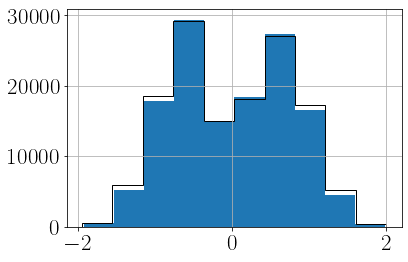

In [267]:
pi0ExpInbProtonCorrected["dvpi0"].Gpx.hist()
pi0ExpInbAllCorrected["dvpi0"].Gpx.hist(histtype='stepfilled', facecolor='none', edgecolor='k')

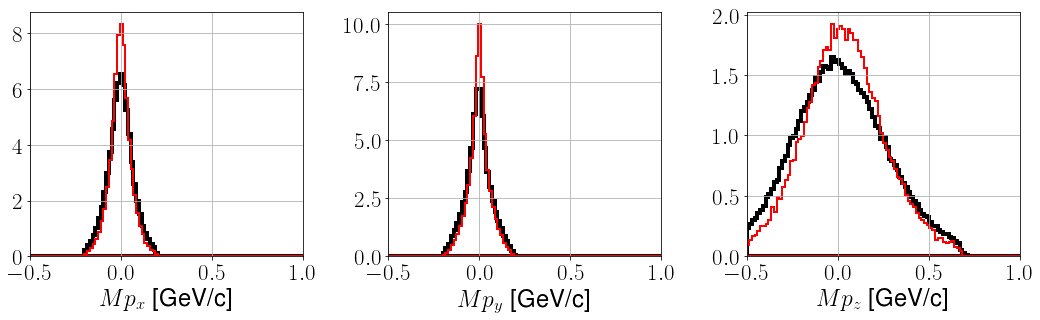

In [285]:
dvpi0 = pi0ExpInbAllCorrected["dvpi0"]
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].set_xlabel("$Mp_x$"+ " [" + GeVc + "]")
axs[1].set_xlabel("$Mp_y$"+ " [" + GeVc + "]")
axs[2].set_xlabel("$Mp_z$"+ " [" + GeVc + "]")
dvpi0.Mpx.hist(ax=axs[0], bins =np.linspace(-0.5, 1, 101), density = True, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=4)
dvpi0.Mpy.hist(ax=axs[1], bins =np.linspace(-0.5, 1, 101), density = True, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=4)
dvpi0.Mpz.hist(ax=axs[2], bins =np.linspace(-0.5, 1, 101), density = True, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=4)

dvpi0Indvpi0Sim.Mpx.hist(ax=axs[0], bins =np.linspace(-0.5, 1, 101), density = True, histtype='stepfilled', facecolor='none', edgecolor='r', linewidth=2)
dvpi0Indvpi0Sim.Mpy.hist(ax=axs[1], bins =np.linspace(-0.5, 1, 101), density = True, histtype='stepfilled', facecolor='none', edgecolor='r', linewidth=2)
dvpi0Indvpi0Sim.Mpz.hist(ax=axs[2], bins =np.linspace(-0.5, 1, 101), density = True, histtype='stepfilled', facecolor='none', edgecolor='r', linewidth=2)

for ax in axs:
    ax.set_xlim([-0.5, 1.0])
plt.tight_layout()
plt.savefig("hints_mom_corr2.pdf")

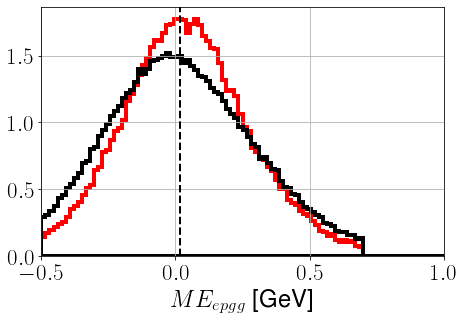

In [286]:
fig, axs = plt.subplots(1, 1, figsize = (7, 5))
dvpi0 = pi0ExpInbAllCorrected["dvpi0"]
dvpi0Indvpi0Sim.ME_epgg.hist(ax=axs,bins =np.linspace(-0.5, 1, 101), density = True, histtype='stepfilled', facecolor='none', edgecolor='r', linewidth=4)
dvpi0.ME_epgg.hist(ax=axs, bins =np.linspace(-0.5, 1, 101), density = True, histtype='stepfilled', facecolor='none', edgecolor='k', linewidth=4)
axs.axvline(0.135**2, color = 'k', linestyle = '--', linewidth = 2)
axs.set_xlim([-0.5, 1])
axs.set_xticks([-0.5, 0, 0.5, 1])
axs.set_xlabel(r"$ME_{epgg}$"+" ["+GeV+"]")
plt.tight_layout()
plt.savefig("shiftsinmissingenergyepgg2.pdf")

In [320]:
t  = 0.2
cont_inb*np.sum((onlydvcsIndvpi0Sim["t2"]>t) & (onlydvcsIndvpi0Sim["t2"]<t+0.1))/((1-cont_inb)*np.sum((onlydvcsIndvcsSim["t2"]<t+0.1)&(onlydvcsIndvcsSim["t2"]>t)))

0.24787031940501922

In [321]:
cont_inb*np.sum((onlydvcsIndvpi0Sim["t2"]>t) & (onlydvcsIndvpi0Sim["t2"]<t+0.1))

492.6002470402805

In [6]:
dvcs = dvcsExpInbAllCorrected["dvcs"]
dvcsFT = dvcs[dvcs.Gstat<2000]
dvcsFD = dvcs[dvcs.Gstat>2000]

In [7]:
len(dvcsFT)

2197

In [8]:
len(dvcsFD)

141947

<AxesSubplot:>

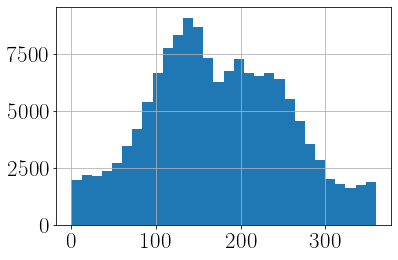

In [10]:
dvcs.phi2.hist(bins=np.linspace(0,360, 31))

In [11]:
#pi0 from experiment, inbending
fname = "~/Dropbox (MIT)/data/data/dvcs_outb.root"
epg = epgFromROOT(fname)
dvpi0 = epg.getDVpi0(correction=True)
dvcs = epg.getDVCS(correction=True, sub2g=False)
dvcsExpOutbAllCorrected = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg}

In [15]:
dvcs = dvcsExpOutbAllCorrected["dvcs"]
dvcsFT = dvcs[dvcs.Gstat<2000]
dvcsFD = dvcs[dvcs.Gstat>2000]
len(dvcsFT)
# len(dvcsFD)

2085